<a href="https://colab.research.google.com/github/HazSyl1/PyTorch-Intro/blob/main/PyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader


In [10]:
torch.cuda.is_available()

True

Files already downloaded and verified
Files already downloaded and verified


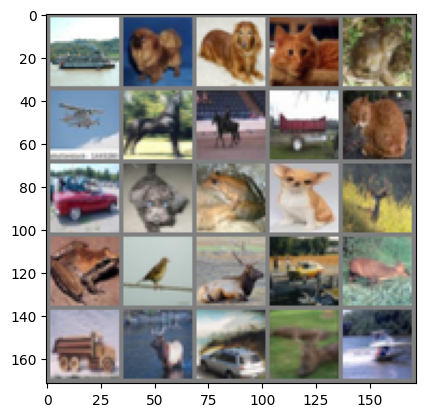

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

num_epoch=10
batch_size=32
learning_rate=0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)
#torchvision.datasets.imagefolder(root=data_dir,transform=transform )
#^^ Use for custom data
train_dataset = torchvision.datasets.CIFAR10(root='./data'
                                             ,train=True,download=True,transform=transform )
test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

classes=['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

def imshow(imgs):
  imgs=imgs/2 +0.5 #un normalise
  npimgs=imgs.numpy()
  plt.imshow(np.transpose(npimgs , (1,2,0)))
  plt.show()

dataiter = iter(train_loader)
images,labels=next(dataiter)
img_grid=torchvision.utils.make_grid(images[0:25],nrow=5)
imshow(img_grid)

In [21]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(3,32,3)
    self.pool=nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(32,64,3)
    self.conv3=nn.Conv2d(64,64,3)
    self.fc1=nn.Linear(64*4*4,64)
    self.fc2=nn.Linear(64 ,10)
  def forward(self ,x):
    x=F.relu(self.conv1(x))
    #print(x.shape)
    x=self.pool(x)
    #print(x.shape)
    x=F.relu(self.conv2(x))
    #print(x.shape)
    x=self.pool(x)
    #print(x.shape)
    x=F.relu(self.conv3(x))
    #print(x.shape)
    x=torch.flatten(x,1)
    #print(x.shape)
    x=F.relu(self.fc1(x))
    #print(x.shape)
    x=self.fc2(x)
    #print(x.shape)
    return x

model=ConvNet().to(device)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

n_total_steps=len(train_loader)
for epoch in range(num_epoch):
  running_loss=0.0

  for i, (images,labels) in enumerate(train_loader):

    images=images.to(device)
    labels=labels.to(device)

    outputs=model(images)
    loss=criterion(outputs,labels)


    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    running_loss+=loss.item()

  print(f"[{epoch+1}/{num_epoch}] loss: {running_loss/n_total_steps}")
print('Finished Training')
PATH='./cnn.pth'
torch.save(model.state_dict(), PATH)





[1/10] loss: 1.5094544309419617
[2/10] loss: 1.152328373793982
[3/10] loss: 0.9829864374392321
[4/10] loss: 0.8757052421951171
[5/10] loss: 0.7948725448917747
[6/10] loss: 0.7285201030897164
[7/10] loss: 0.676835976984359
[8/10] loss: 0.6303821876311408
[9/10] loss: 0.5883537994903856
[10/10] loss: 0.5505375831709103
Finished Training


In [23]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH))
loaded_model.to(device)

loaded_model.eval()
#^sets up config for eval purpose
with torch.no_grad():
  n_correct=0
  n_correct2=0
  n_samples=len(test_loader.dataset)

  for images, labels in test_loader:
    images=images.to(device)
    labels=labels.to(device)

    outputs=model(images)

    _,predict=torch.max(outputs,1)
    n_correct+=(predict==labels).sum().item()

    outputs2=loaded_model(images)
    _,predict2=torch.max(outputs2,1)
    n_correct2+= (predict2 ==labels).sum().item()

  acc= 100 * n_correct / n_samples
  print(f"Accuracy: {acc}")

  acc= 100 * n_correct2 / n_samples
  print(f"Accuracy of loaded model: {acc}")





Accuracy: 72.31
Accuracy of loaded model: 72.31
